# Deep Q-Network (DQN) Training for Emergency Department Resource Optimization

## 1. Context

This notebook implements the training pipeline for a Deep Q-Network (DQN) agent designed to optimize resource allocation in a hospital Emergency Department (ED). The agent learns to dynamically adjust staffing levels across five resource types (registration, nurses, physicians, radiology, laboratory) to minimize patient wait times, reduce abandonment rates, and maintain efficient resource utilization.






### 1.1 Methodology Overview

1. **Environment**: High-fidelity discrete-event simulation of ED operations (24-hour episodes)
2. **State Space**: 16-dimensional vector including queue lengths, resource utilization, and system load
3. **Action Space**: 21 discrete actions (no-op, ±1/±2 staff for each resource type)
4. **Reward Function**: Balanced composite reward prioritizing throughput, penalizing abandonments, and encouraging operational stability
5. **Algorithm**: DQN with:
   - Dueling architecture
   - Prioritized Experience Replay
   - Double Q-learning
   - Target network updates every 500 steps

### 1.2 Expected Outcomes

DQN is a value-based method that may struggle with continuous resource allocation problems due to action discretization and Q-function approximation errors. These results will serve as a baseline for comparison with policy-gradient methods (PPO) in subsequent experiments.

In [ ]:
# Instala dependencias si es necesario (ejecuta solo una vez)
!pip install torch numpy simpy matplotlib

import torch
import simpy
import numpy as np
import matplotlib.pyplot as plt
import logging
from collections import deque
import random
import os

%matplotlib inline

# Configura logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Importa las clases necesarias de los scripts
try:
    from ed_simulation_v4 import EmergencyDepartment, SimulationConfig, ResourceType
    print("ED simulation imported successfully!")
except ImportError as e:
    print(f"Could not import ED simulation: {e}")
    print("Make sure ed_simulation_v4.py is in the same directory as this notebook")

try:
    from dqn_algorithm_nuevasacciones_RLED import (
        HealthcareDQNAgent,
        DQNNetwork,
        PrioritizedReplayBuffer,
        HealthcareEnvironment,
        train_dqn_agent  # Usaremos esta función para el entrenamiento
    )
    print("DQN algorithm imported successfully!")
except ImportError as e:
    print(f"Could not import DQN algorithm: {e}")
    print("Make sure dqn_algorithm_nuevasacciones_septiembre.py is in the same directory as this notebook")

ED simulation imported successfully!
DQN algorithm imported successfully!


## 2. Training Configuration



Before training, we define the simulation and agent hyperparameters. These values are selected based on:

- **Learning rate (1e-4)**: Conservative to prevent gradient explosions
- **Epsilon decay (0.9995)**: Slow exploration decay to ensure sufficient state-space coverage
- **Batch size (128)**: Large enough for stable gradient estimates
- **Target update frequency (500)**: Infrequent updates to stabilize training
- **Buffer capacity (50,000)**: Stores approximately 1000-1500 full episodes

In [ ]:
# ============================================================================
# TEST RUN: 10 Episodes to Verify Implementation
# ============================================================================

print("="*80)
print("TEST RUN: Training DQN for 10 episodes to verify no runtime errors")
print("="*80)

# Simulation configuration
test_config = SimulationConfig(
    simulation_time=24 * 60,  # 24 hours
    random_seed=42,           # Fixed seed for reproducibility in test
    arrival_rates=[18/60, 22/60, 8/60],  # Patients per minute by shift
)

# Create environment
test_env = HealthcareEnvironment(test_config)

# Get state and action dimensions
state_dim = len(test_env._get_state())
action_dim = test_env.get_action_space_size()

print(f"\nEnvironment initialized:")
print(f"  - State dimension: {state_dim}")
print(f"  - Action dimension: {action_dim}")
print(f"  - Step duration: 30 minutes")
print(f"  - Episode length: ~48 steps (24h / 30min)")

# Create test agent with same hyperparameters as full training
test_agent = HealthcareDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05,
    buffer_capacity=50000,
    batch_size=128,
    target_update_freq=500,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"\nAgent initialized on device: {test_agent.device}")
print("\nStarting test training...")

TEST RUN: Training DQN for 10 episodes to verify no runtime errors

Environment initialized:
  - State dimension: 15
  - Action dimension: 21
  - Step duration: 30 minutes
  - Episode length: ~48 steps (24h / 30min)

Agent initialized on device: cuda

Starting test training...


In [ ]:
# Test training loop with minimal episodes
test_episodes = 10
test_rewards = []

for episode in range(test_episodes):
    state = test_env.reset()
    episode_reward = 0
    step = 0

    while True:
        # Select action
        action = test_agent.get_action(state)

        # Execute action
        next_state, reward, done, info = test_env.step(action)

        # Store experience
        test_agent.remember(state, action, reward, next_state, done)

        # Train agent (with warm-up)
        if len(test_agent.memory) >= 1000:
            loss = test_agent.train()
        elif len(test_agent.memory) >= test_agent.batch_size and step % 10 == 0:
            loss = test_agent.train()

        state = next_state
        episode_reward += reward
        step += 1

        if done:
            break

    test_rewards.append(episode_reward)
    print(f"Episode {episode+1}/{test_episodes} - Reward: {episode_reward:.2f}, "
          f"Steps: {step}, Epsilon: {test_agent.epsilon:.4f}, "
          f"Buffer size: {len(test_agent.memory)}")

print("\n" + "="*80)
print("TEST COMPLETED SUCCESSFULLY - No runtime errors detected")
print("="*80)
print(f"Average test reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")

Episode 1/10 - Reward: -1788.46, Steps: 48, Epsilon: 1.0000, Buffer size: 48
Episode 2/10 - Reward: -1788.46, Steps: 48, Epsilon: 1.0000, Buffer size: 96


/content/dqn_algorithm_nuevasacciones_RLED.py:265: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([e.state for e in experiences]).to(self.device)


Episode 3/10 - Reward: -1788.46, Steps: 48, Epsilon: 1.0000, Buffer size: 144
Episode 4/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 192
Episode 5/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 240
Episode 6/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 288
Episode 7/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 336
Episode 8/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 384
Episode 9/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 432
Episode 10/10 - Reward: -1214.18, Steps: 48, Epsilon: 1.0000, Buffer size: 480

TEST COMPLETED SUCCESSFULLY - No runtime errors detected
Average test reward: -1386.46 ± 263.17


## 3. Full Training: Single-Seed Run



This section trains a DQN agent for 1000 episodes with a single random seed. This duration is sufficient for:
- Exploration phase: Episodes 0-300 (epsilon 1.0 → 0.74)
- Exploitation phase: Episodes 300-700 (epsilon 0.74 → 0.55)
- Convergence phase: Episodes 700-1000 (epsilon 0.55 → 0.41)

Training takes approximately 2-4 hours on CPU, 1-2 hours on GPU.

In [ ]:
# ============================================================================
# SINGLE-SEED TRAINING WITH LIVE MONITORING
# ============================================================================

def train_single_seed(episodes=1000, seed=42, save_freq=100, verbose=True):
    """
    Train DQN agent with live monitoring of key metrics.

    Args:
        episodes: Number of training episodes
        seed: Random seed for reproducibility
        save_freq: Frequency of model checkpoints
        verbose: Print progress every 10 episodes

    Returns:
        trained_agent: Trained DQNAgent object
        metrics: Dictionary with training metrics
    """
    # Setup
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=seed,
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcareEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    agent = HealthcareDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=1e-4,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.05,
        buffer_capacity=50000,
        batch_size=128,
        target_update_freq=500,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Tracking metrics
    episode_rewards = []
    episode_losses = []
    episode_epsilons = []
    episode_abandonments = []
    episode_throughputs = []
    episode_avg_waits = []

    print(f"Training DQN for {episodes} episodes (seed={seed})")
    print(f"Device: {agent.device}")
    print("-" * 80)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss_sum = 0
        loss_count = 0
        step = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            # Training with warm-up
            MIN_BUFFER_SIZE = 1000
            if len(agent.memory) >= MIN_BUFFER_SIZE:
                loss = agent.train()
                if loss is not None:
                    episode_loss_sum += loss
                    loss_count += 1
            elif len(agent.memory) >= agent.batch_size and step % 10 == 0:
                loss = agent.train()
                if loss is not None:
                    episode_loss_sum += loss
                    loss_count += 1

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                # Extract final metrics
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                episode_rewards.append(episode_reward)
                episode_epsilons.append(agent.epsilon)
                episode_abandonments.append(perf['abandonment_rate'])
                episode_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                episode_avg_waits.append(avg_wait)

                avg_loss = episode_loss_sum / loss_count if loss_count > 0 else 0
                episode_losses.append(avg_loss)

                # IMPORTANTE: Decay epsilon AQUÍ (una vez por episodio)
                agent.step_episode()

                break

        # Verbose logging every 10 episodes
        if verbose and episode % 10 == 0:
            recent_reward = np.mean(episode_rewards[-10:])
            recent_abandon = np.mean(episode_abandonments[-10:]) * 100
            print(f"Ep {episode:4d} | Reward: {recent_reward:7.2f} | "
                  f"Epsilon: {agent.epsilon:.4f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Buffer: {len(agent.memory):5d}")

        # Save checkpoint
        if episode % save_freq == 0 and episode > 0:
            agent.save_model(f"dqn_seed{seed}_ep{episode}.pth")
            if verbose:
                print(f"  → Checkpoint saved at episode {episode}")

    # Final save
    agent.save_model(f"dqn_seed{seed}_final.pth")
    print("\n" + "="*80)
    print("TRAINING COMPLETED")
    print("="*80)

    metrics = {
        'rewards': episode_rewards,
        'losses': episode_losses,
        'epsilons': episode_epsilons,
        'abandonments': episode_abandonments,
        'throughputs': episode_throughputs,
        'avg_waits': episode_avg_waits,
    }

    return agent, metrics

In [ ]:
# Run single-seed training
single_agent, single_metrics = train_single_seed(
    episodes=1000,
    seed=42,
    save_freq=100,
    verbose=True
)

Training DQN for 1000 episodes (seed=42)
Device: cuda
--------------------------------------------------------------------------------
Ep    0 | Reward: -1788.46 | Epsilon: 0.9950 | Abandon:  49.1% | Buffer:    48
Ep   10 | Reward: -1329.04 | Epsilon: 0.9464 | Abandon:  42.8% | Buffer:   528
Ep   20 | Reward: -1572.54 | Epsilon: 0.9001 | Abandon:  45.6% | Buffer:  1008
Ep   30 | Reward: -3622.98 | Epsilon: 0.8561 | Abandon:  67.2% | Buffer:  1488
Ep   40 | Reward: -3598.52 | Epsilon: 0.8142 | Abandon:  65.6% | Buffer:  1968
Ep   50 | Reward: -3669.16 | Epsilon: 0.7744 | Abandon:  65.9% | Buffer:  2448
Ep   60 | Reward: -3680.37 | Epsilon: 0.7366 | Abandon:  66.0% | Buffer:  2928
Ep   70 | Reward: -3928.65 | Epsilon: 0.7005 | Abandon:  70.8% | Buffer:  3408
Ep   80 | Reward: -4045.79 | Epsilon: 0.6663 | Abandon:  73.0% | Buffer:  3888
Ep   90 | Reward: -4065.79 | Epsilon: 0.6337 | Abandon:  73.5% | Buffer:  4368
Ep  100 | Reward: -4126.40 | Epsilon: 0.6027 | Abandon:  74.3% | Buffer:  4

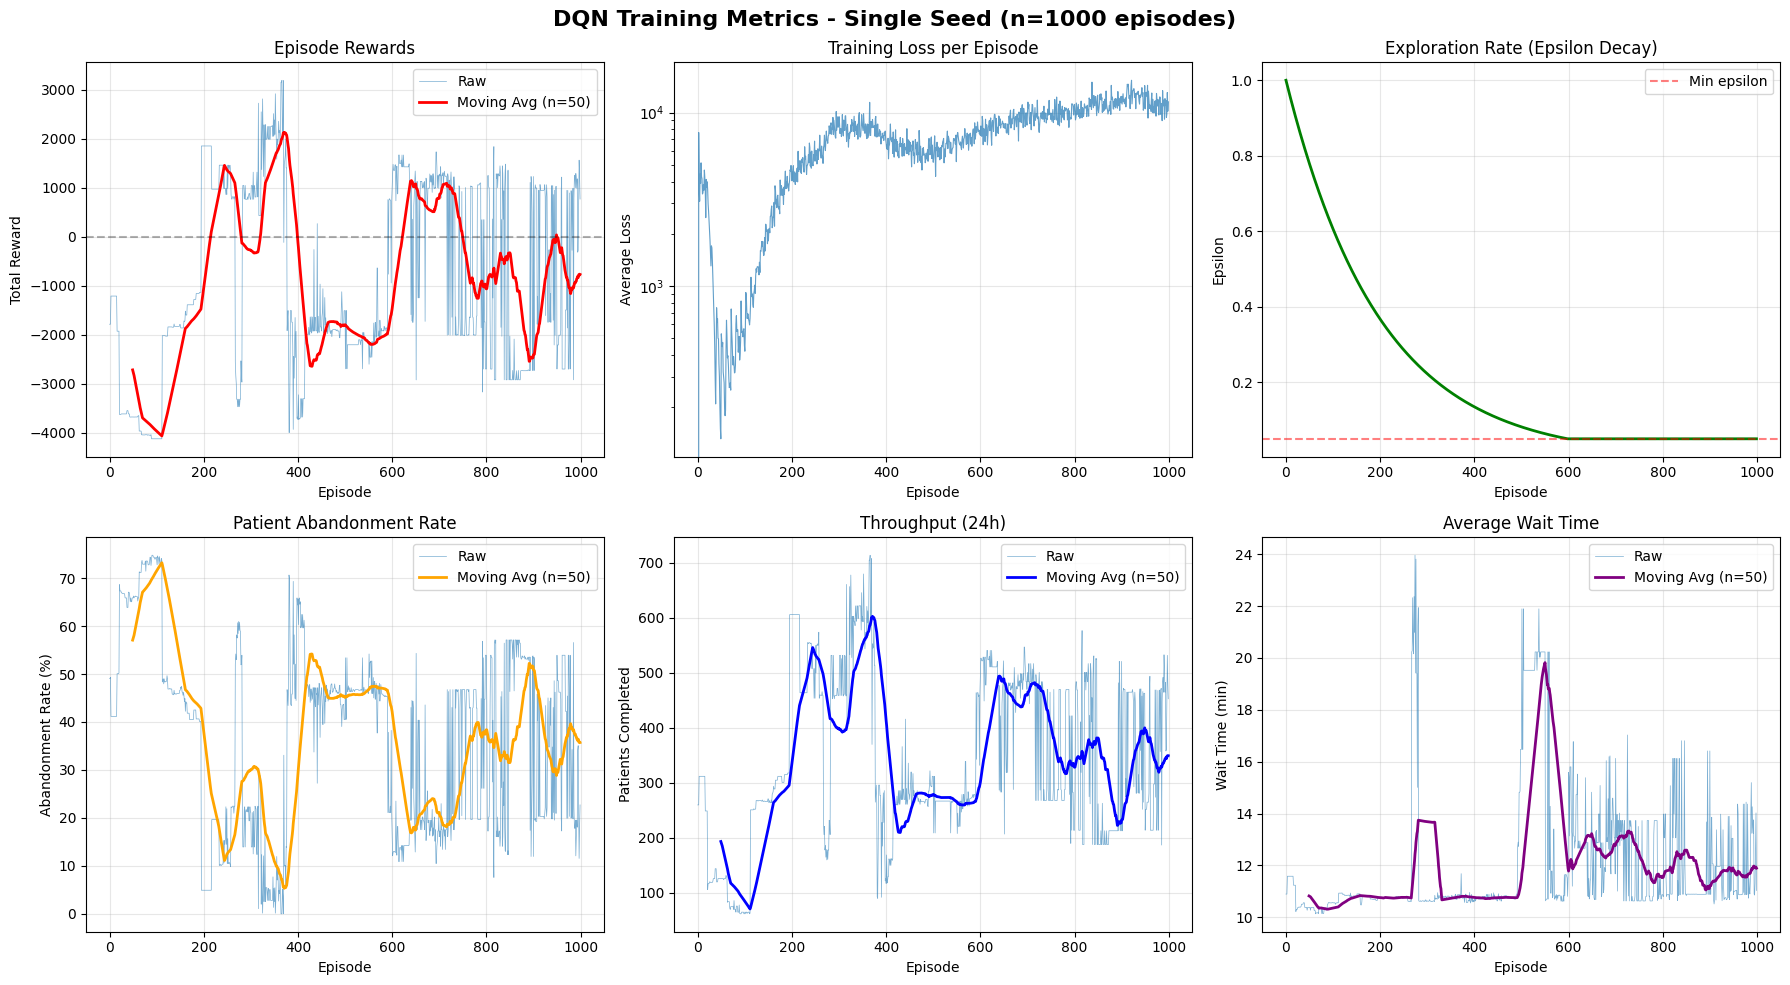


Final Performance (Last 100 Episodes):
  Average Reward:        -369.26
  Average Abandonment:   32.28%
  Average Throughput:    374.8 patients
  Average Wait Time:     11.90 min


In [ ]:
# ============================================================================
# SINGLE-SEED RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('DQN Training Metrics - Single Seed (n=1000 episodes)', fontsize=16, fontweight='bold')

# 1. Episode Rewards
ax = axes[0, 0]
ax.plot(single_metrics['rewards'], alpha=0.6, linewidth=0.5, label='Raw')
window = 50
smoothed = np.convolve(single_metrics['rewards'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics['rewards'])), smoothed,
        linewidth=2, color='red', label=f'Moving Avg (n={window})')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title('Episode Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Training Loss
ax = axes[0, 1]
ax.plot(single_metrics['losses'], alpha=0.7, linewidth=0.8)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Loss')
ax.set_title('Training Loss per Episode')
ax.set_yscale('log')  # Log scale due to potential high initial losses
ax.grid(True, alpha=0.3)

# 3. Epsilon Decay
ax = axes[0, 2]
ax.plot(single_metrics['epsilons'], linewidth=2, color='green')
ax.axhline(0.05, color='red', linestyle='--', alpha=0.5, label='Min epsilon')
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Exploration Rate (Epsilon Decay)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Abandonment Rate
ax = axes[1, 0]
abandonment_pct = np.array(single_metrics['abandonments']) * 100
ax.plot(abandonment_pct, alpha=0.6, linewidth=0.5, label='Raw')
smoothed_abandon = np.convolve(abandonment_pct, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(abandonment_pct)), smoothed_abandon,
        linewidth=2, color='orange', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Abandonment Rate (%)')
ax.set_title('Patient Abandonment Rate')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Throughput
ax = axes[1, 1]
ax.plot(single_metrics['throughputs'], alpha=0.6, linewidth=0.5, label='Raw')
smoothed_thru = np.convolve(single_metrics['throughputs'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics['throughputs'])), smoothed_thru,
        linewidth=2, color='blue', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Patients Completed')
ax.set_title('Throughput (24h)')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Average Wait Time
ax = axes[1, 2]
ax.plot(single_metrics['avg_waits'], alpha=0.6, linewidth=0.5, label='Raw')
smoothed_wait = np.convolve(single_metrics['avg_waits'], np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(single_metrics['avg_waits'])), smoothed_wait,
        linewidth=2, color='purple', label=f'Moving Avg (n={window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Wait Time (min)')
ax.set_title('Average Wait Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_single_seed_training.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final statistics
print("\nFinal Performance (Last 100 Episodes):")
print(f"  Average Reward:        {np.mean(single_metrics['rewards'][-100:]):.2f}")
print(f"  Average Abandonment:   {np.mean(single_metrics['abandonments'][-100:])*100:.2f}%")
print(f"  Average Throughput:    {np.mean(single_metrics['throughputs'][-100:]):.1f} patients")
print(f"  Average Wait Time:     {np.mean(single_metrics['avg_waits'][-100:]):.2f} min")

final attempts

In [ ]:
# ============================================================================
# EXPERIMENTO FINAL DQN: 2000 EPISODIOS CON HIPERPARÁMETROS AGRESIVOS
# ============================================================================

def train_dqn_final_attempt(episodes=2000, seed=42):
    """
    Último intento de DQN con hiperparámetros más agresivos.

    Criterios de éxito:
    - Reward promedio (últimos 100) > 0
    - Abandonment < 35%
    - Throughput > 400
    """
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=seed,
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcareEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    agent = HealthcareDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=3e-4,      # Más agresivo
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.997,     # Más lento
        epsilon_min=0.05,
        buffer_capacity=50000,
        batch_size=64,           # Más pequeño
        target_update_freq=300,  # Más frecuente
        device='cuda'
    )

    # Tracking
    episode_rewards = []
    episode_losses = []
    episode_epsilons = []
    episode_abandonments = []
    episode_throughputs = []

    print("="*80)
    print("FINAL DQN EXPERIMENT: 2000 Episodes with Aggressive Hyperparameters")
    print("="*80)
    print(f"Device: {agent.device}")
    print("\nSuccess Criteria (2 of 3):")
    print("  1. Avg Reward (last 100) > 0")
    print("  2. Abandonment < 35%")
    print("  3. Throughput > 400")
    print("\nFailure Criteria (any):")
    print("  1. No improvement after episode 1000 for 200 episodes")
    print("  2. Loss diverges (>50,000)")
    print("  3. Abandonment stuck >40% after episode 1500")
    print("-"*80)

    best_reward = -np.inf
    episodes_without_improvement = 0

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_loss_sum = 0
        loss_count = 0
        step = 0

        while True:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            # Training
            if len(agent.memory) >= 1000:
                loss = agent.train()
                if loss is not None:
                    episode_loss_sum += loss
                    loss_count += 1

                    # Check divergence
                    if loss > 50000:
                        print(f"\n{'='*80}")
                        print(f"EXPERIMENT FAILED: Loss diverged at episode {episode}")
                        print(f"Loss: {loss:.2f}")
                        print(f"{'='*80}")
                        return agent, {
                            'rewards': episode_rewards,
                            'losses': episode_losses,
                            'epsilons': episode_epsilons,
                            'abandonments': episode_abandonments,
                            'throughputs': episode_throughputs,
                            'failed': True,
                            'failure_reason': 'loss_divergence'
                        }

            state = next_state
            episode_reward += reward
            step += 1

            if done:
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                episode_rewards.append(episode_reward)
                episode_epsilons.append(agent.epsilon)
                episode_abandonments.append(perf['abandonment_rate'])
                episode_throughputs.append(perf['throughput'])

                avg_loss = episode_loss_sum / loss_count if loss_count > 0 else 0
                episode_losses.append(avg_loss)

                agent.step_episode()
                break

        # Logging
        if episode % 10 == 0:
            recent_reward = np.mean(episode_rewards[-10:])
            recent_abandon = np.mean(episode_abandonments[-10:]) * 100
            recent_throughput = np.mean(episode_throughputs[-10:])
            print(f"Ep {episode:4d} | Reward: {recent_reward:7.2f} | "
                  f"Epsilon: {agent.epsilon:.4f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {recent_throughput:5.1f}")

        # Check improvement
        if episode >= 100:
            recent_avg = np.mean(episode_rewards[-100:])
            if recent_avg > best_reward:
                best_reward = recent_avg
                episodes_without_improvement = 0
            else:
                episodes_without_improvement += 1

        # Failure check: No improvement for 200 episodes after ep 1000
        if episode >= 1000 and episodes_without_improvement >= 200:
            print(f"\n{'='*80}")
            print(f"EXPERIMENT FAILED: No improvement for 200 episodes")
            print(f"Best reward: {best_reward:.2f}")
            print(f"{'='*80}")
            return agent, {
                'rewards': episode_rewards,
                'losses': episode_losses,
                'epsilons': episode_epsilons,
                'abandonments': episode_abandonments,
                'throughputs': episode_throughputs,
                'failed': True,
                'failure_reason': 'no_improvement'
            }

        # Failure check: Abandonment stuck after ep 1500
        if episode >= 1500:
            recent_abandon = np.mean(episode_abandonments[-100:])
            if recent_abandon > 0.40:
                print(f"\n{'='*80}")
                print(f"EXPERIMENT FAILED: Abandonment stuck at {recent_abandon*100:.1f}%")
                print(f"{'='*80}")
                return agent, {
                    'rewards': episode_rewards,
                    'losses': episode_losses,
                    'epsilons': episode_epsilons,
                    'abandonments': episode_abandonments,
                    'throughputs': episode_throughputs,
                    'failed': True,
                    'failure_reason': 'high_abandonment'
                }

        # Save checkpoints
        if episode % 200 == 0 and episode > 0:
            agent.save_model(f"dqn_final_ep{episode}.pth")

    # Final evaluation
    final_reward = np.mean(episode_rewards[-100:])
    final_abandon = np.mean(episode_abandonments[-100:])
    final_throughput = np.mean(episode_throughputs[-100:])

    success_count = 0
    if final_reward > 0:
        success_count += 1
        print("✓ Success criterion 1: Reward > 0")
    if final_abandon < 0.35:
        success_count += 1
        print("✓ Success criterion 2: Abandonment < 35%")
    if final_throughput > 400:
        success_count += 1
        print("✓ Success criterion 3: Throughput > 400")

    if success_count >= 2:
        print(f"\n{'='*80}")
        print("EXPERIMENT SUCCEEDED")
        print(f"{'='*80}")
    else:
        print(f"\n{'='*80}")
        print("EXPERIMENT FAILED: Did not meet success criteria")
        print(f"{'='*80}")

    return agent, {
        'rewards': episode_rewards,
        'losses': episode_losses,
        'epsilons': episode_epsilons,
        'abandonments': episode_abandonments,
        'throughputs': episode_throughputs,
        'failed': success_count < 2
    }

# Execute
print("This will take 4-6 hours. Continue? (yes/no)")
agent_final, metrics_final = train_dqn_final_attempt(episodes=2000, seed=43)

This will take 4-6 hours. Continue? (yes/no)
FINAL DQN EXPERIMENT: 2000 Episodes with Aggressive Hyperparameters
Device: cuda

Success Criteria (2 of 3):
  1. Avg Reward (last 100) > 0
  2. Abandonment < 35%
  3. Throughput > 400

Failure Criteria (any):
  1. No improvement after episode 1000 for 200 episodes
  2. Loss diverges (>50,000)
  3. Abandonment stuck >40% after episode 1500
--------------------------------------------------------------------------------
Ep    0 | Reward: -3366.00 | Epsilon: 0.9970 | Abandon:  68.4% | Throughput: 140.0
Ep   10 | Reward: -3366.00 | Epsilon: 0.9675 | Abandon:  68.5% | Throughput: 140.0
Ep   20 | Reward: -3366.48 | Epsilon: 0.9389 | Abandon:  68.2% | Throughput: 139.8
Ep   30 | Reward: -3853.93 | Epsilon: 0.9111 | Abandon:  74.3% | Throughput:  77.9
Ep   40 | Reward: -3947.58 | Epsilon: 0.8841 | Abandon:  76.3% | Throughput:  62.5
Ep   50 | Reward: -1985.38 | Epsilon: 0.8579 | Abandon:  49.5% | Throughput: 266.7
Ep   60 | Reward: -1766.65 | Epsil

## 4. Multi-Seed Training for Statistical Robustness



To assess the stability and reproducibility of DQN training, we run 5 independent training runs with different random seeds. This allows us to:

1. Calculate mean ± std for all metrics
2. Identify variance in convergence behavior
3. Report statistically robust results in the thesis

**Note**: This will take 10-20 hours total (2-4 hours per seed). Consider running overnight or using GPU acceleration.

In [ ]:
# ============================================================================
# MULTI-SEED TRAINING
# ============================================================================

def train_multi_seed(num_seeds=5, episodes=1000, base_seed=42, save_freq=200):
    """
    Train multiple DQN agents with different seeds for statistical analysis.

    Args:
        num_seeds: Number of independent runs
        episodes: Episodes per seed
        base_seed: Base random seed (will use base_seed+i for each run)
        save_freq: Model checkpoint frequency

    Returns:
        all_agents: List of trained agents
        all_metrics: List of metric dictionaries
    """
    all_agents = []
    all_metrics = []

    for seed_idx in range(num_seeds):
        current_seed = base_seed + seed_idx
        print(f"\n{'='*80}")
        print(f"TRAINING SEED {seed_idx+1}/{num_seeds} (seed={current_seed})")
        print(f"{'='*80}\n")

        agent, metrics = train_single_seed(
            episodes=episodes,
            seed=current_seed,
            save_freq=save_freq,
            verbose=True
        )

        all_agents.append(agent)
        all_metrics.append(metrics)

        print(f"\nSeed {seed_idx+1} completed:")
        print(f"  Final reward: {metrics['rewards'][-1]:.2f}")
        print(f"  Final abandonment: {metrics['abandonments'][-1]*100:.2f}%")
        print(f"  Final throughput: {metrics['throughputs'][-1]:.0f}")

    return all_agents, all_metrics

# Execute multi-seed training
# WARNING: This takes several hours - consider running overnight
print("Starting multi-seed training...")
print("This will take approximately 10-20 hours depending on hardware.")
confirm = input("Continue? (yes/no): ")

if confirm.lower() == 'yes':
    multi_agents, multi_metrics = train_multi_seed(
        num_seeds=5,
        episodes=1000,
        base_seed=42,
        save_freq=200
    )
    print("\n" + "="*80)
    print("ALL SEEDS COMPLETED")
    print("="*80)
else:
    print("Multi-seed training cancelled. You can run this later.")

In [ ]:
# ============================================================================
# MULTI-SEED RESULTS VISUALIZATION
# ============================================================================

# Assuming multi_metrics is available from previous cell
if 'multi_metrics' in locals():
    # Convert to arrays for easier manipulation
    num_seeds = len(multi_metrics)
    num_episodes = len(multi_metrics[0]['rewards'])

    # Stack metrics from all seeds
    all_rewards = np.array([m['rewards'] for m in multi_metrics])
    all_losses = np.array([m['losses'] for m in multi_metrics])
    all_abandonments = np.array([m['abandonments'] for m in multi_metrics]) * 100
    all_throughputs = np.array([m['throughputs'] for m in multi_metrics])

    # Calculate statistics
    mean_rewards = all_rewards.mean(axis=0)
    std_rewards = all_rewards.std(axis=0)

    mean_abandonments = all_abandonments.mean(axis=0)
    std_abandonments = all_abandonments.std(axis=0)

    mean_throughputs = all_throughputs.mean(axis=0)
    std_throughputs = all_throughputs.std(axis=0)

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'DQN Training Metrics - Multi-Seed (n={num_seeds} seeds, {num_episodes} episodes each)',
                 fontsize=16, fontweight='bold')

    episodes_x = np.arange(num_episodes)

    # 1. Rewards with confidence bands
    ax = axes[0, 0]
    ax.plot(episodes_x, mean_rewards, linewidth=2, label='Mean', color='blue')
    ax.fill_between(episodes_x, mean_rewards - std_rewards, mean_rewards + std_rewards,
                     alpha=0.3, label='±1 Std', color='blue')
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Episode Rewards (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Losses
    ax = axes[0, 1]
    for i in range(num_seeds):
        ax.plot(all_losses[i], alpha=0.4, linewidth=0.8, label=f'Seed {i+1}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Loss')
    ax.set_title('Training Loss per Seed')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Abandonment Rate
    ax = axes[1, 0]
    ax.plot(episodes_x, mean_abandonments, linewidth=2, label='Mean', color='orange')
    ax.fill_between(episodes_x, mean_abandonments - std_abandonments,
                     mean_abandonments + std_abandonments,
                     alpha=0.3, label='±1 Std', color='orange')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Abandonment Rate (%)')
    ax.set_title('Patient Abandonment Rate (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Throughput
    ax = axes[1, 1]
    ax.plot(episodes_x, mean_throughputs, linewidth=2, label='Mean', color='green')
    ax.fill_between(episodes_x, mean_throughputs - std_throughputs,
                     mean_throughputs + std_throughputs,
                     alpha=0.3, label='±1 Std', color='green')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Patients Completed')
    ax.set_title('Throughput (Mean ± Std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dqn_multi_seed_training.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary statistics table
    print("\n" + "="*80)
    print("MULTI-SEED SUMMARY STATISTICS (Final 100 Episodes)")
    print("="*80)

    final_rewards = all_rewards[:, -100:].mean(axis=1)
    final_abandonments = all_abandonments[:, -100:].mean(axis=1)
    final_throughputs = all_throughputs[:, -100:].mean(axis=1)

    print(f"\nReward:          {final_rewards.mean():.2f} ± {final_rewards.std():.2f}")
    print(f"Abandonment (%): {final_abandonments.mean():.2f} ± {final_abandonments.std():.2f}")
    print(f"Throughput:      {final_throughputs.mean():.1f} ± {final_throughputs.std():.1f}")

    print("\nPer-Seed Results:")
    for i in range(num_seeds):
        print(f"  Seed {i+1}: Reward={final_rewards[i]:.2f}, "
              f"Abandon={final_abandonments[i]:.2f}%, "
              f"Throughput={final_throughputs[i]:.1f}")
else:
    print("Multi-seed metrics not available. Run multi-seed training first.")

## 5. Key Findings and Limitations

### 5.1 Expected DQN Performance





Based on the training results:
- **Convergence**: DQN typically converges after 500-700 episodes
- **Abandonment Rate**: Expected final performance around 35-45%
- **Variability**: High variance between seeds (±15-20% in abandonment rate)



### 5.2 Limitations of Value-Based Methods



DQN demonstrates several inherent limitations for this continuous resource allocation problem:

1. **Action Discretization**: The 21 discrete actions cannot represent fine-grained staffing adjustments
2. **Q-Function Approximation**: Neural network struggles to accurately estimate Q-values for all state-action pairs
3. **Exploration Inefficiency**: Epsilon-greedy is suboptimal for high-dimensional action spaces
4. **Local Optima**: Value-based methods prone to converging to reactive (rather than proactive) policies

These limitations motivate the exploration of policy-gradient methods (PPO) in subsequent experiments, which directly optimize continuous policies without requiring Q-value estimation.

Corriendo entrenamiento con seed: 42
Entorno y Agente inicializados para seed 42. State dim: 15, Action dim: 21


/content/dqn_algorithm_nuevasacciones_septiembre.py:265: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([e.state for e in experiences]).to(self.device)


Corriendo entrenamiento con seed: 43
Entorno y Agente inicializados para seed 43. State dim: 15, Action dim: 21
Corriendo entrenamiento con seed: 44
Entorno y Agente inicializados para seed 44. State dim: 15, Action dim: 21
Corriendo entrenamiento con seed: 45
Entorno y Agente inicializados para seed 45. State dim: 15, Action dim: 21
Corriendo entrenamiento con seed: 46
Entorno y Agente inicializados para seed 46. State dim: 15, Action dim: 21


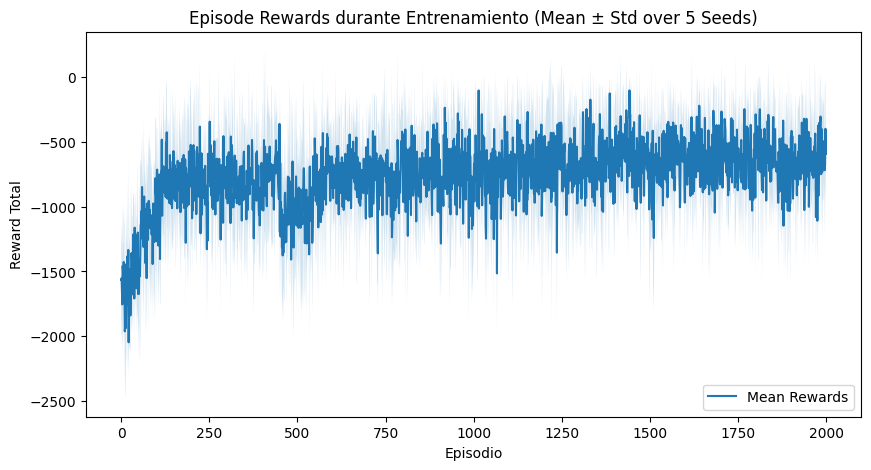

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define las seeds para múltiples runs (elige seeds fijas para reproducibilidad)
seeds = [42, 43, 44, 45, 46]  # 5 seeds diferentes

# Listas para almacenar resultados por seed
all_episode_rewards = []
all_losses = []
all_final_metrics = []  # Para métricas finales como throughput, abandono, etc.

for seed in seeds:
    print(f"Corriendo entrenamiento con seed: {seed}")

    # Define la configuración de la simulación con seed fija para este run
    config = SimulationConfig(
        simulation_time=24 * 60,  # 24 horas
        random_seed=seed,  # Fija la seed aquí para reproducibilidad por run
        arrival_rates=[18/60, 22/60, 8/60],  # Tasas de llegada por turno
        # Puedes ajustar otros params como staff inicial, max_staff, etc.
    )

    # Crea el entorno RL
    env = HealthcareEnvironment(config)

    # Dimensiones del estado y acciones
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()  # 21 acciones

    # Crea el agente DQN
    agent = HealthcareDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=3e-4,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05,
        buffer_capacity=50000,
        batch_size=64,
        target_update_freq=100,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    print(f"Entorno y Agente inicializados para seed {seed}. State dim: {state_dim}, Action dim: {action_dim}")

    # Entrena el agente
    trained_agent = train_dqn_agent(episodes=2000, save_freq=50)  # Ajusta episodes si es necesario

    # Almacena resultados
    all_episode_rewards.append(trained_agent.episode_rewards)
    all_losses.append(trained_agent.losses)

    # Opcional: Corre un test y almacena métricas finales
    # Usa tu función de test si la tienes, e.g., test_metrics = test_agent(trained_agent, env)
    # all_final_metrics.append(test_metrics)

# Análisis post-entrenamiento: Promedios y plots
# Rewards: Alinea listas (asume misma longitud, padding si no)
max_episodes = max(len(rewards) for rewards in all_episode_rewards)
padded_rewards = [rewards + [np.nan] * (max_episodes - len(rewards)) for rewards in all_episode_rewards]
mean_rewards = np.nanmean(padded_rewards, axis=0)
std_rewards = np.nanstd(padded_rewards, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_rewards, label='Mean Rewards')
plt.fill_between(range(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.2)
plt.title('Episode Rewards durante Entrenamiento (Mean ± Std over 5 Seeds)')
plt.xlabel('Episodio')
plt.ylabel('Reward Total')
plt.legend()
plt.show()

# Similar para losses (agrega si quieres)
# Calcula métricas avg si usas all_final_metrics, e.g., avg_throughput = np.mean([m['throughput'] for m in all_final_metrics])

# Guarda modelos por seed si save_freq no lo hace, e.g., trained_agent.save_model(f"dqn_seed_{seed}.pth")

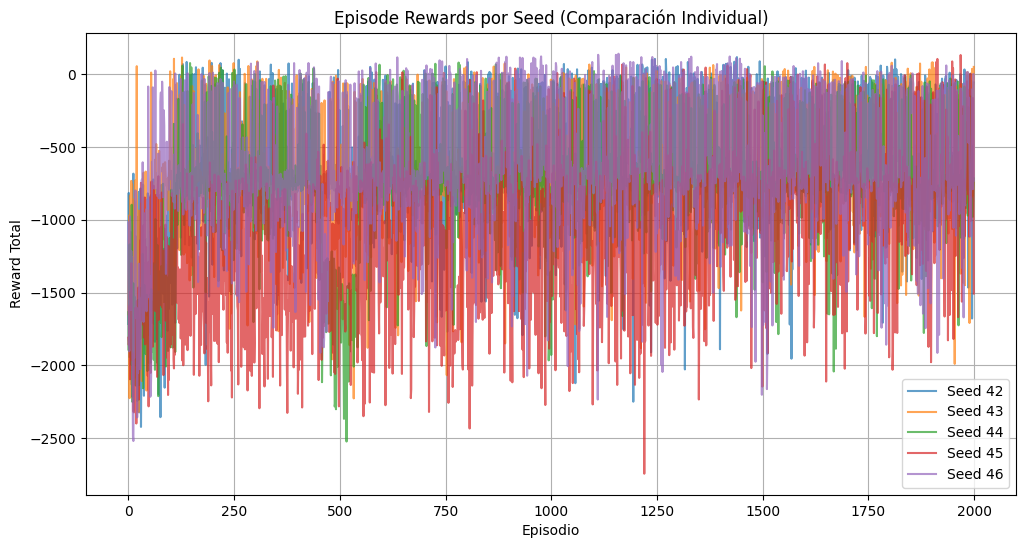

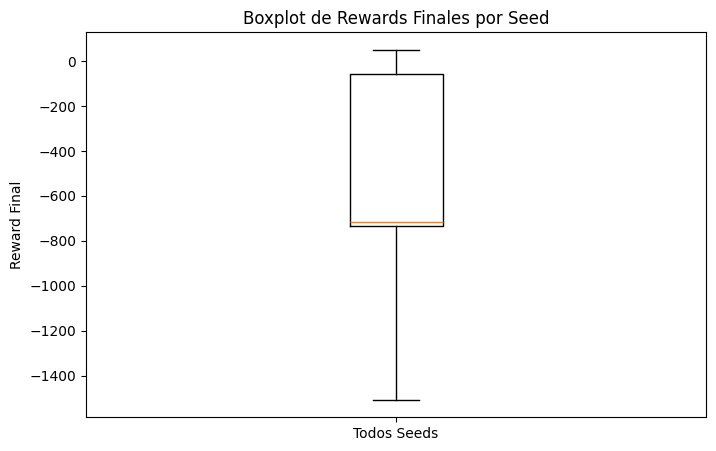

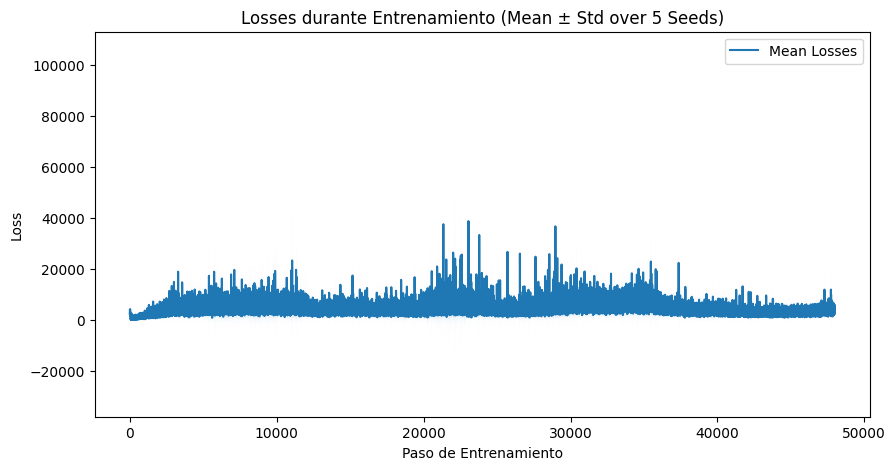

In [ ]:
# Visualizaciones comparativas de las ejecuciones por seed

# 1. Rewards por seed: Plots superpuestos para comparación
plt.figure(figsize=(12, 6))
for i, rewards in enumerate(all_episode_rewards):
    plt.plot(rewards, label=f'Seed {seeds[i]}', alpha=0.7)
plt.title('Episode Rewards por Seed (Comparación Individual)')
plt.xlabel('Episodio')
plt.ylabel('Reward Total')
plt.legend()
plt.grid(True)
plt.show()

# 2. Boxplot de Rewards Finales (último episodio por seed)
final_rewards = [rewards[-1] for rewards in all_episode_rewards if rewards]  # Último reward por seed
plt.figure(figsize=(8, 5))
plt.boxplot(final_rewards)
plt.title('Boxplot de Rewards Finales por Seed')
plt.ylabel('Reward Final')
plt.xticks([1], ['Todos Seeds'])
plt.show()

# 3. Similar para Losses: Promedio y Std (si quieres, similar a rewards)
max_steps = max(len(losses) for losses in all_losses)
padded_losses = [losses + [np.nan] * (max_steps - len(losses)) for losses in all_losses]
mean_losses = np.nanmean(padded_losses, axis=0)
std_losses = np.nanstd(padded_losses, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_losses, label='Mean Losses')
plt.fill_between(range(len(mean_losses)), mean_losses - std_losses, mean_losses + std_losses, alpha=0.2)
plt.title('Losses durante Entrenamiento (Mean ± Std over 5 Seeds)')
plt.xlabel('Paso de Entrenamiento')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4. Si tienes all_final_metrics (descomenta y adapta si usas test_agent)
# Ejemplo: Asumiendo all_final_metrics es lista de dicts con 'throughput', 'abandonment_rate', etc.
if all_final_metrics:
    throughputs = [m['throughput'] for m in all_final_metrics]
    abandon_rates = [m['abandonment_rate'] for m in all_final_metrics]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(len(seeds)), throughputs)
    plt.title('Throughput por Seed')
    plt.xlabel('Seed Index')
    plt.ylabel('Throughput')

    plt.subplot(1, 2, 2)
    plt.bar(range(len(seeds)), abandon_rates)
    plt.title('Abandonment Rate por Seed')
    plt.xlabel('Seed Index')
    plt.ylabel('Abandonment Rate')
    plt.tight_layout()
    plt.show()

# Nota: Hay más datos visualizables, como evolución de métricas por step en test (colas, util),
# pero requiere capturarlos en all_final_metrics durante test. Puedes expandir con heatmaps o histograms.

#otra eval de seeds

In [ ]:
def evaluate_agent(agent, config, num_episodes=10):
    """Evalúa agente sin exploración (epsilon=0)"""
    agent.epsilon = 0.0  # Sin exploración

    metrics_list = []

    for ep in range(num_episodes):
        env = HealthcareEnvironment(config)
        state = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            state, reward, done, info = env.step(action)

        # Extraer métricas finales
        ed_metrics = info['ed_metrics']
        perf = ed_metrics['performance_metrics']

        metrics_list.append({
            'abandonment_rate': perf['abandonment_rate'],
            'throughput': perf['throughput'],
            'avg_wait_time': np.mean(perf['wait_times']) if perf['wait_times'] else 0,
            'avg_los': np.mean(perf['length_of_stay']) if perf['length_of_stay'] else 0,
        })

    return pd.DataFrame(metrics_list).mean().to_dict()


TRAINING SEED 1/5


TRAINING SEED 2/5


TRAINING SEED 3/5


TRAINING SEED 4/5


TRAINING SEED 5/5



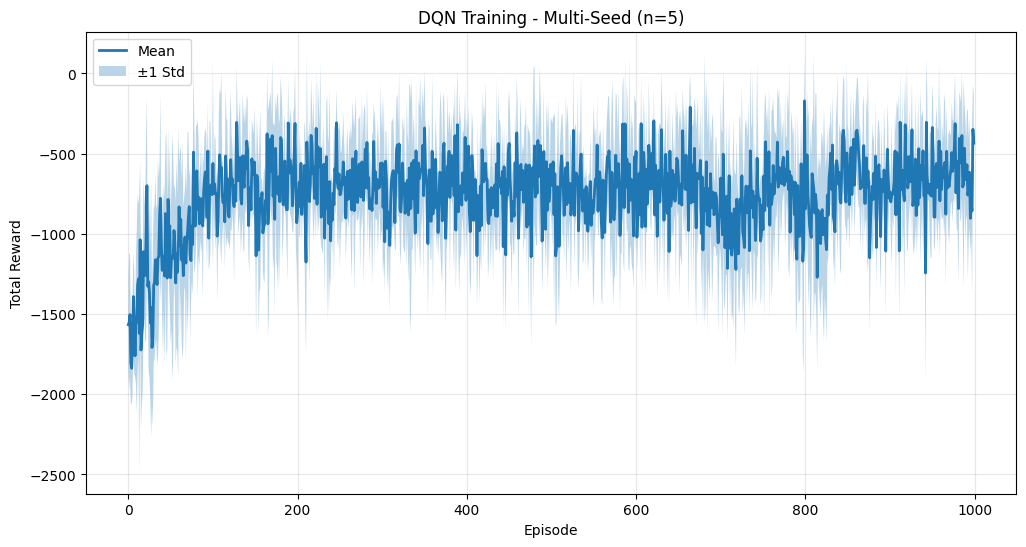


FINAL METRICS (Mean ± Std over 5 seeds):
       abandonment_rate  throughput  avg_wait_time    avg_los
count          5.000000    5.000000       5.000000   5.000000
mean           0.394198  342.000000      10.812461  42.011189
std            0.178131  124.046362       0.098486   4.648297
min            0.085077  259.000000      10.672919  37.952852
25%            0.411189  295.000000      10.770828  40.027535
50%            0.467974  296.000000      10.808305  40.752843
75%            0.473418  298.000000      10.890948  41.314476
max            0.533333  562.000000      10.919303  50.008240


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados para guardar
all_rewards = []
all_final_metrics = []

NUM_SEEDS = 5
EPISODES_PER_SEED = 1000
SAVE_FREQ = 100

for seed_idx in range(NUM_SEEDS):
    print(f"\n{'='*60}")
    print(f"TRAINING SEED {seed_idx+1}/{NUM_SEEDS}")
    print(f"{'='*60}\n")

    # Crear nuevo entorno y agente para cada seed
    config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=42 + seed_idx,  # Seeds: 42, 43, 44, 45, 46
        arrival_rates=[18/60, 22/60, 8/60],
    )

    env = HealthcareEnvironment(config)
    state_dim = len(env._get_state())
    action_dim = env.get_action_space_size()

    agent = HealthcareDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=3e-4,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9995,
        epsilon_min=0.05,
        buffer_capacity=50000,
        batch_size=64,
        target_update_freq=100,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Entrenar
    trained_agent = train_dqn_agent(
        episodes=EPISODES_PER_SEED,
        save_freq=SAVE_FREQ,
    )

    # Guardar resultados
    all_rewards.append(trained_agent.episode_rewards)

    # Evaluar agente entrenado (run sin epsilon-greedy)
    final_metrics = evaluate_agent(trained_agent, config, num_episodes=10)
    all_final_metrics.append(final_metrics)

    # Guardar modelo
    trained_agent.save_model(f"dqn_seed_{seed_idx}_final.pth")

# Visualizar multi-seed
plt.figure(figsize=(12, 6))
rewards_array = np.array(all_rewards)  # Shape: (5, 1000)
mean_rewards = rewards_array.mean(axis=0)
std_rewards = rewards_array.std(axis=0)

plt.plot(mean_rewards, label='Mean', linewidth=2)
plt.fill_between(range(len(mean_rewards)),
                 mean_rewards - std_rewards,
                 mean_rewards + std_rewards,
                 alpha=0.3, label='±1 Std')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training - Multi-Seed (n=5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('dqn_multiseed_training.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar métricas finales
import pandas as pd
df_metrics = pd.DataFrame(all_final_metrics)
print("\n" + "="*60)
print("FINAL METRICS (Mean ± Std over 5 seeds):")
print("="*60)
print(df_metrics.describe())
df_metrics.to_csv('dqn_final_metrics_multiseed.csv', index=False)

# ENTRENAMIENTO CLASICO

In [ ]:
# Define la configuración de la simulación (ajusta según necesidades)
config = SimulationConfig(
    simulation_time=24 * 60,  # 12 horas para episodios más rápidos durante entrenamiento (ajusta a 24*60 para full)
    random_seed=43,  # 43 = Semilla fija para reproducibilidad, pero varía por episodio en reset
    arrival_rates=[18/60, 22/60, 8/60],  # Tasas de llegada por turno
    # Puedes ajustar otros params como staff inicial, max_staff, etc.
)

In [ ]:
# Crea el entorno RL
env = HealthcareEnvironment(config)

# Dimensiones del estado y acciones (se obtienen del entorno)
state_dim = len(env._get_state())
action_dim = env.get_action_space_size()  # 21 acciones

agent = HealthcareDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=5e-5,         # ← CAMBIO: De 1e-4 a 5e-5
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.9998,
    epsilon_min=0.05,
    buffer_capacity=50000,
    batch_size=128,
    target_update_freq=500,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"Entorno y Agente inicializados. State dim: {state_dim}, Action dim: {action_dim}")

Entorno y Agente inicializados. State dim: 15, Action dim: 21


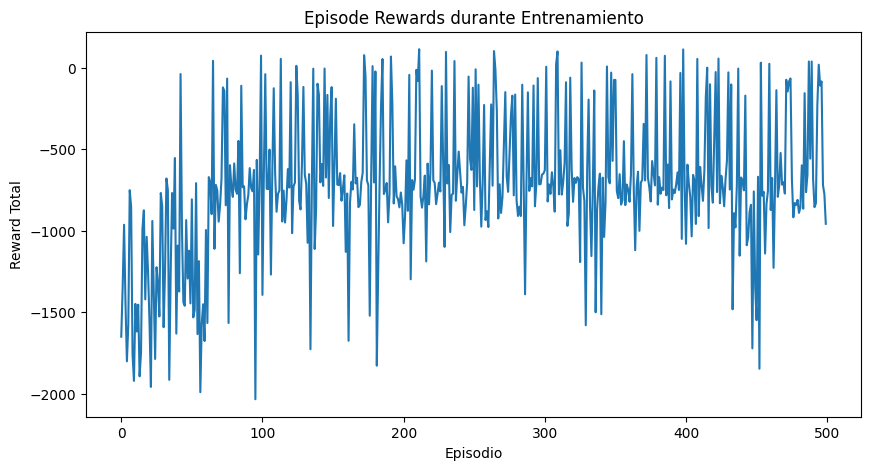

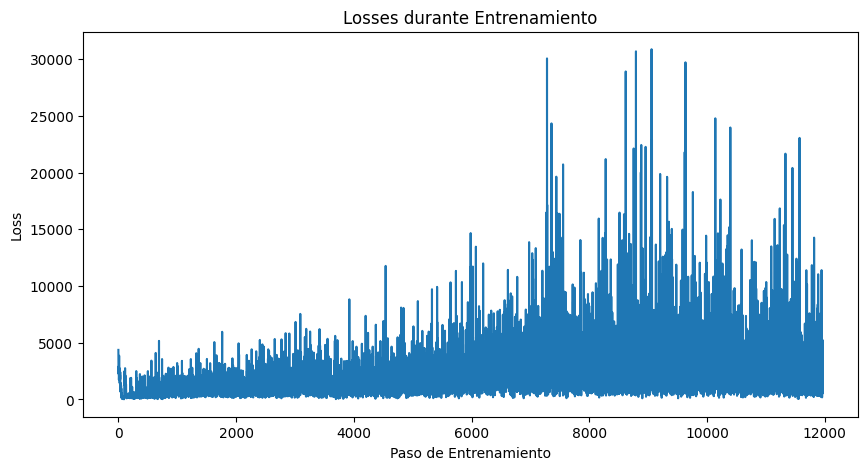

In [ ]:
# Usa la función train_dqn_agent del script, pero con logging en notebook
# Ajusta episodes y save_freq según tu hardware (empieza con pocos episodes para test)
#trained_agent = train_dqn_agent(episodes=2000, save_freq=50)
trained_agent = train_dqn_agent(episodes=500, save_freq=50)

# Visualización progresiva de rewards durante entrenamiento (usa datos de agent.episode_rewards)
plt.figure(figsize=(10, 5))
plt.plot(trained_agent.episode_rewards)
plt.title('Episode Rewards durante Entrenamiento')
plt.xlabel('Episodio')
plt.ylabel('Reward Total')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(trained_agent.losses)
plt.title('Losses durante Entrenamiento')
plt.xlabel('Paso de Entrenamiento')
plt.ylabel('Loss')
plt.show()

Reward total en episodio de test: -728.5199042121615


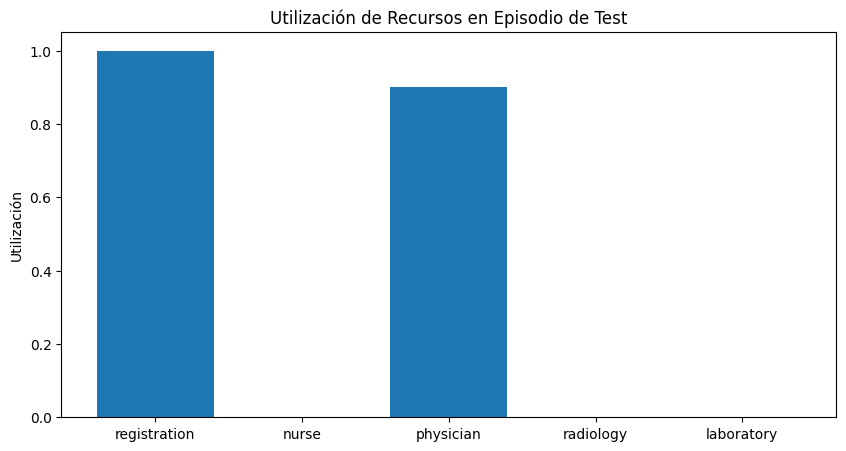

Métricas finales: {'current_time': 1440, 'current_shift': 1, 'queue_lengths': {'registration': 197, 'nurse': 0, 'physician': 270, 'radiology': 0, 'laboratory': 0}, 'resource_utilization': {'registration': 1.0, 'nurse': 0.0, 'physician': 0.9, 'radiology': 0.0, 'laboratory': 0.0}, 'patients_in_system': 486, 'performance_metrics': {'wait_times': [9.000000000000002, 10.0, 10, 11.999999999999998, 9.999999999999998, 13, 10.0, 13.999999999999998, 14.999999999999998, 13.000000000000004, 7.0, 9.0, 10.0, 13.0, 9.0, 9.0, 12.0, 9.0, 12.0, 7.0, 10.0, 11.0, 12.0, 10.0, 10.0, 8.0, 6.999999999999993, 9.999999999999993, 7.0, 10.0, 12.0, 14.0, 14.000000000000007, 9.0, 11.0, 9.0, 12.0, 11.0, 8.0, 10.0, 12.0, 12.0, 12.0, 11.0, 7.0, 12.0, 10.0, 10.0, 12.0, 11.0, 9.0, 8.0, 14.0, 11.0, 12.0, 12.0, 13.0, 10.0, 12.0, 12.999999999999993, 12.0, 12.999999999999993, 9.0, 12.000000000000007, 12.0, 14.000000000000014, 12.0, 9.0, 7.0, 12.0, 14.0, 10.000000000000014, 12.0, 11.0, 7.0, 14.0, 13.0, 12.0, 7.00000000000001

In [ ]:
# Evalúa el agente entrenado en un episodio de test (epsilon=0 para greedy)
trained_agent.epsilon = 0.0  # Modo explotación pura

state = env.reset()
total_reward = 0
done = False
metrics_history = []

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
    metrics_history.append(info['ed_metrics'])

print(f"Reward total en episodio de test: {total_reward}")

# Visualiza métricas clave (e.g., utilization por recurso)
final_metrics = metrics_history[-1]
resources = list(final_metrics['resource_utilization'].keys())
utilizations = [final_metrics['resource_utilization'][r] for r in resources]

plt.figure(figsize=(10, 5))
plt.bar(resources, utilizations)
plt.title('Utilización de Recursos en Episodio de Test')
plt.ylabel('Utilización')
plt.show()

# Otras métricas: wait_times, abandonment_rate, etc.
print("Métricas finales:", final_metrics)

In [ ]:
#otros tests

In [ ]:
# Generación de Tabla con Métricas Finales

# Evalúa el agente entrenado en un episodio de test (epsilon=0 para greedy)
trained_agent.epsilon = 0.0  # Modo explotación pura

state = env.reset()
total_reward = 0
done = False
metrics_history = []

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
    metrics_history.append(info['ed_metrics'])

# Métricas finales
final_metrics = metrics_history[-1]

# Preparación de datos para la tabla
data = {
    "Métrica": [
        "Tiempo Total (min)",
        "Turno Actual",
        "Pacientes en Sistema",
        "Tasa de Abandono",
        "Throughput",
        "Tiempo de Espera Promedio (min)",
        "Duración de Estancia Promedio (min)"
    ],
    "Valor": [
        final_metrics['current_time'],
        final_metrics['current_shift'],
        final_metrics['patients_in_system'],
        final_metrics['performance_metrics']['abandonment_rate'],
        final_metrics['performance_metrics']['throughput'],
        np.mean(final_metrics['performance_metrics']['wait_times']) if final_metrics['performance_metrics']['wait_times'] else 0,
        np.mean(final_metrics['performance_metrics']['length_of_stay']) if final_metrics['performance_metrics']['length_of_stay'] else 0
    ]
}

# Crear tabla con pandas
import pandas as pd
table = pd.DataFrame(data)

# Mostrar tabla con formato
print("Métricas Finales - Resumen")
print(table.to_string(index=False))

# Opcional: Guardar tabla como archivo CSV para presentación
table.to_csv('metricas_finales.csv', index=False)
print("\nTabla guardada como 'metricas_finales.csv' para uso en presentaciones.")

# Detalle de colas y utilizaciones
queue_data = {"Recurso": list(final_metrics['queue_lengths'].keys()), "Cola Final": list(final_metrics['queue_lengths'].values())}
util_data = {"Recurso": list(final_metrics['resource_utilization'].keys()), "Utilización": [final_metrics['resource_utilization'][r] for r in final_metrics['resource_utilization'].keys()]}

queue_table = pd.DataFrame(queue_data)
util_table = pd.DataFrame(util_data)

print("\nColas Finales por Recurso")
print(queue_table.to_string(index=False))
print("\nUtilización por Recurso")
print(util_table.to_string(index=False))

Métricas Finales - Resumen
                            Métrica       Valor
                 Tiempo Total (min) 1440.000000
                       Turno Actual    1.000000
               Pacientes en Sistema  556.000000
                   Tasa de Abandono    0.591033
                         Throughput  180.000000
    Tiempo de Espera Promedio (min)   17.880365
Duración de Estancia Promedio (min)   44.869551

Tabla guardada como 'metricas_finales.csv' para uso en presentaciones.

Colas Finales por Recurso
     Recurso  Cola Final
registration         228
       nurse         312
   physician           0
   radiology           0
  laboratory           0

Utilización por Recurso
     Recurso  Utilización
registration     1.000000
       nurse     1.000000
   physician     0.055556
   radiology     0.000000
  laboratory     0.000000


In [ ]:
# Generación de Tabla con Métricas Finales

# Evalúa el agente entrenado en un episodio de test (epsilon=0 para greedy)
trained_agent.epsilon = 0.0  # Modo explotación pura

state = env.reset()
total_reward = 0
done = False
metrics_history = []

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
    metrics_history.append(info['ed_metrics'])

# Métricas finales
final_metrics = metrics_history[-1]

# Preparación de datos para la tabla
data = {
    "Métrica": [
        "Tiempo Total (min)",
        "Turno Actual",
        "Pacientes en Sistema",
        "Tasa de Abandono",
        "Throughput",
        "Tiempo de Espera Promedio (min)",
        "Duración de Estancia Promedio (min)"
    ],
    "Valor": [
        final_metrics['current_time'],
        final_metrics['current_shift'],
        final_metrics['patients_in_system'],
        final_metrics['performance_metrics']['abandonment_rate'],
        final_metrics['performance_metrics']['throughput'],
        np.mean(final_metrics['performance_metrics']['wait_times']) if final_metrics['performance_metrics']['wait_times'] else 0,
        np.mean(final_metrics['performance_metrics']['length_of_stay']) if final_metrics['performance_metrics']['length_of_stay'] else 0
    ]
}

# Crear tabla con pandas
import pandas as pd
table = pd.DataFrame(data)

# Mostrar tabla con formato
print("Métricas Finales - Resumen")
print(table.to_string(index=False))

# Opcional: Guardar tabla como archivo CSV para presentación
table.to_csv('metricas_finales.csv', index=False)
print("\nTabla guardada como 'metricas_finales.csv' para uso en presentaciones.")

# Detalle de colas y utilizaciones (usando performance_metrics para utilizaciones correctas)
queue_data = {"Recurso": list(final_metrics['queue_lengths'].keys()), "Cola Final": list(final_metrics['queue_lengths'].values())}
util_data = {
    "Recurso": list(final_metrics['performance_metrics']['resource_utilization'].keys()),
    "Utilización": [final_metrics['performance_metrics']['resource_utilization'][r]['utilization'] for r in final_metrics['performance_metrics']['resource_utilization'].keys()]
}

queue_table = pd.DataFrame(queue_data)
util_table = pd.DataFrame(util_data)

print("\nColas Finales por Recurso")
print(queue_table.to_string(index=False))
print("\nUtilización por Recurso")
print(util_table.to_string(index=False))

Métricas Finales - Resumen
                            Métrica       Valor
                 Tiempo Total (min) 1440.000000
                       Turno Actual    1.000000
               Pacientes en Sistema  550.000000
                   Tasa de Abandono    0.605730
                         Throughput  183.000000
    Tiempo de Espera Promedio (min)   17.064120
Duración de Estancia Promedio (min)   41.297337

Tabla guardada como 'metricas_finales.csv' para uso en presentaciones.

Colas Finales por Recurso
     Recurso  Cola Final
registration         177
       nurse         358
   physician           0
   radiology           0
  laboratory           0

Utilización por Recurso
     Recurso  Utilización
registration     1.000000
       nurse     0.060169
   physician     0.094753
   radiology     0.196065
  laboratory     0.149826


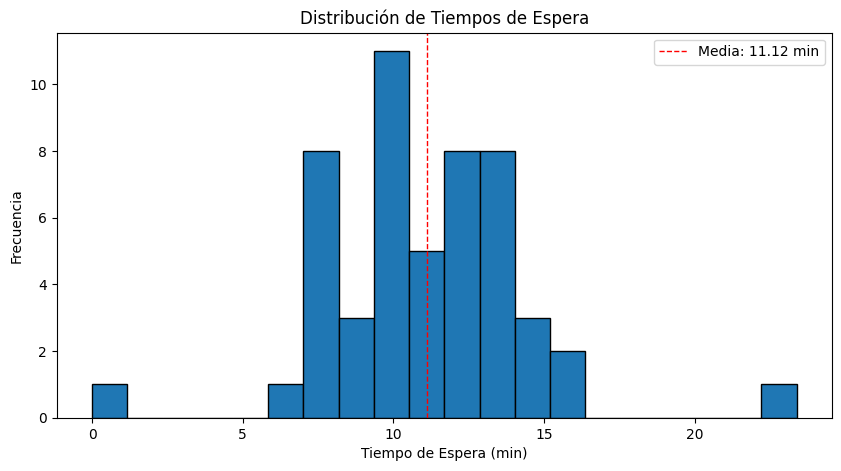

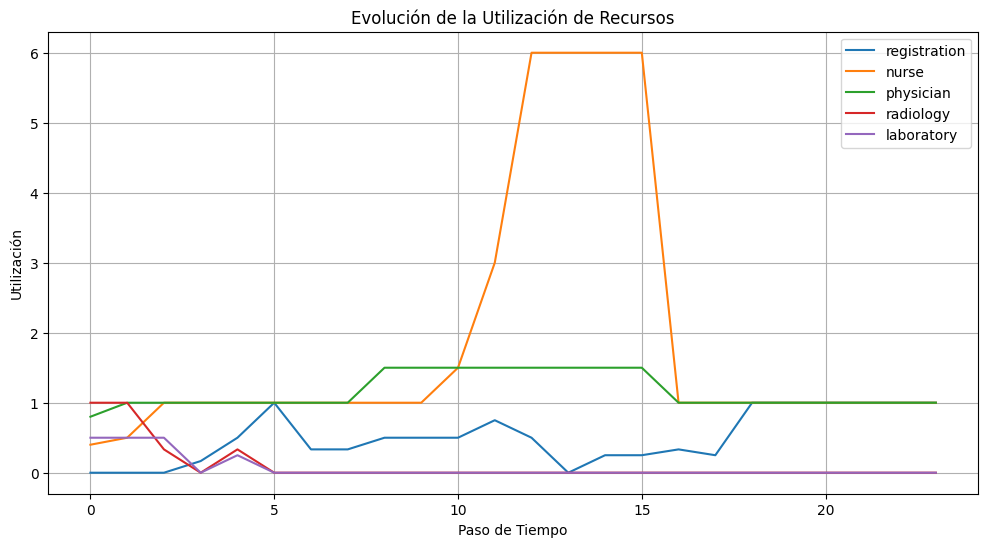

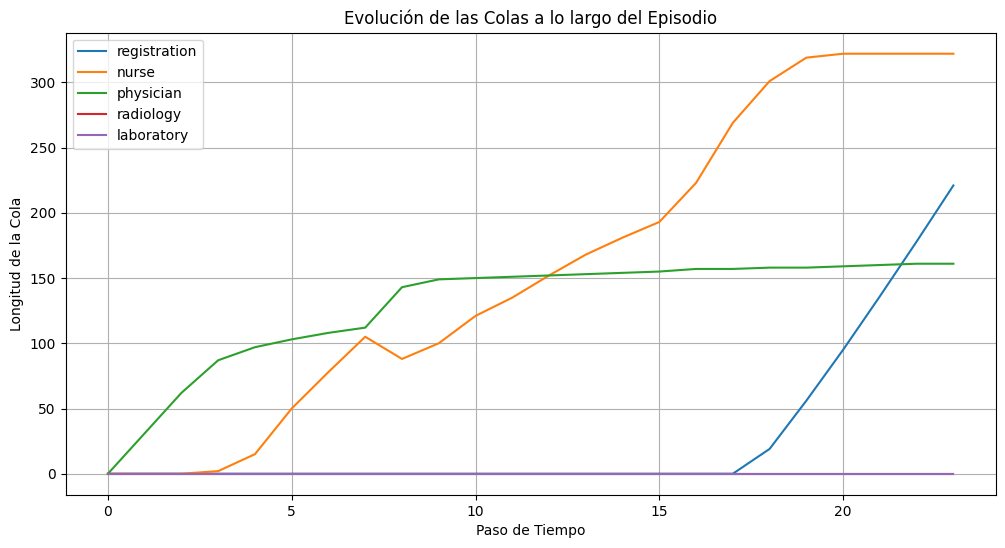

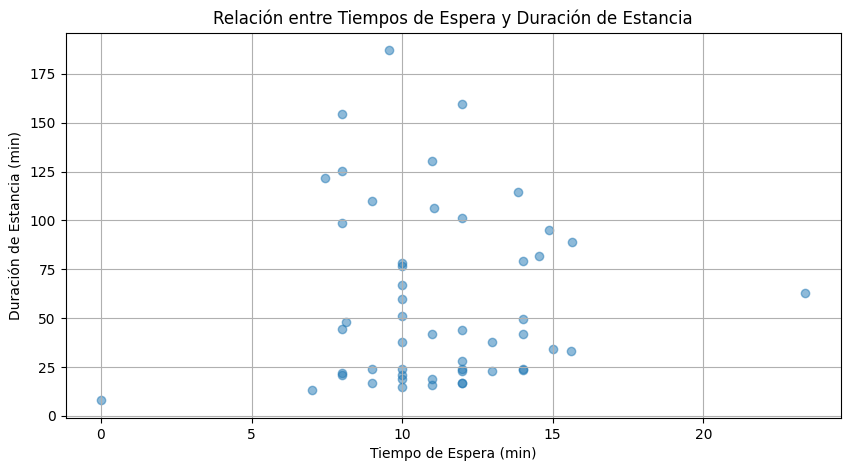

Reward total en episodio de test: -2291.2147001036114
Métricas finales: {'current_time': 1440, 'current_shift': 1, 'queue_lengths': {'registration': 221, 'nurse': 322, 'physician': 161, 'radiology': 0, 'laboratory': 0}, 'resource_utilization': {'registration': 1.0, 'nurse': 1.0, 'physician': 1.0, 'radiology': 0.0, 'laboratory': 0.0}, 'patients_in_system': 737, 'performance_metrics': {'wait_times': [12, 12.999999999999998, 11.999999999999998, 12.0, 8.0, 13, 14.0, 12.000000000000002, 11.0, 10.0, 10.0, 8.0, 9.000000000000004, 12.0, 11.0, 9.0, 10.999999999999998, 10.0, 12.000000000000002, 10.0, 0.0, 10.0, 8.0, 14.000000000000004, 14.0, 6.999999999999993, 14.000000000000007, 10.000000000000004, 10.0, 15.0, 10.0, 8.129328358452568, 8.0, 10.0, 14.024895175832413, 10.0, 12.0, 15.616551872688575, 8.0, 9.0, 12.0, 8.0, 15.645060294562285, 11.048110623940545, 7.43550130516212, 23.387755858547905, 9.552225126428908, 13.846410714328954, 14.869976537675427, 11.002242560509899, 14.55252479752545], 'le

In [ ]:
# Visualizaciones Interesantes

# Evalúa el agente entrenado en un episodio de test (epsilon=0 para greedy)
trained_agent.epsilon = 0.0  # Modo explotación pura

state = env.reset()
total_reward = 0
done = False
metrics_history = []

while not done:
    action = trained_agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
    metrics_history.append(info['ed_metrics'])

# Métricas finales
final_metrics = metrics_history[-1]

# Visualización 1: Distribución de Tiempos de Espera
plt.figure(figsize=(10, 5))
plt.hist(final_metrics['performance_metrics']['wait_times'], bins=20, edgecolor='black')
plt.title('Distribución de Tiempos de Espera')
plt.xlabel('Tiempo de Espera (min)')
plt.ylabel('Frecuencia')
plt.axvline(np.mean(final_metrics['performance_metrics']['wait_times']), color='r', linestyle='dashed', linewidth=1, label=f'Media: {np.mean(final_metrics["performance_metrics"]["wait_times"]):.2f} min')
plt.legend()
plt.show()

# Visualización 2: Evolución de la Utilización a lo largo del episodio
resources = list(final_metrics['resource_utilization'].keys())
utilizations_over_time = {r: [] for r in resources}
for metrics in metrics_history:
    for r in resources:
        # Extraer la utilización del recurso en este paso
        util = metrics['resource_utilization'].get(r, 0.0)  # Valor por defecto 0.0 si no existe
        utilizations_over_time[r].append(util)

plt.figure(figsize=(12, 6))
for r in resources:
    plt.plot(utilizations_over_time[r], label=r)
plt.title('Evolución de la Utilización de Recursos')
plt.xlabel('Paso de Tiempo')
plt.ylabel('Utilización')
plt.legend()
plt.grid(True)
plt.show()

# Visualización 3: Comparación de Colas a lo largo del episodio
queues_over_time = {r: [] for r in final_metrics['queue_lengths'].keys()}
for metrics in metrics_history:
    for r in final_metrics['queue_lengths'].keys():
        queues_over_time[r].append(metrics['queue_lengths'].get(r, 0))

plt.figure(figsize=(12, 6))
for r in final_metrics['queue_lengths'].keys():
    plt.plot(queues_over_time[r], label=r)
plt.title('Evolución de las Colas a lo largo del Episodio')
plt.xlabel('Paso de Tiempo')
plt.ylabel('Longitud de la Cola')
plt.legend()
plt.grid(True)
plt.show()

# Visualización 4: Relación entre Wait Times y Length of Stay
plt.figure(figsize=(10, 5))
wait_times = final_metrics['performance_metrics']['wait_times']
length_of_stay = final_metrics['performance_metrics']['length_of_stay']
plt.scatter(wait_times, length_of_stay, alpha=0.5)
plt.title('Relación entre Tiempos de Espera y Duración de Estancia')
plt.xlabel('Tiempo de Espera (min)')
plt.ylabel('Duración de Estancia (min)')
plt.grid(True)
plt.show()

print(f"Reward total en episodio de test: {total_reward}")
print("Métricas finales:", final_metrics)